In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

In [3]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.6.0


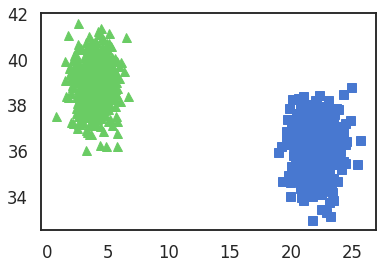

In [4]:
from sklearn import datasets

X, y = datasets.make_blobs(n_samples=1000, centers=2, n_features=2, center_box=(0, 50))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

In [66]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)
print('len train:', len(X_train))
print('len test:', len(X_test))

len train: 800
len test: 200


In [39]:
BATCH_SIZE = 32
n_features = 2
training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).float())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).float())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [56]:
len(testing_dataset)

200

# Define accuracy & Model

In [152]:
def accuracy(model, test_loader):
    correct = 0

    for examples, labels in test_loader:
        output = model.forward(examples)
        batch_correct = torch.sum(torch.abs(torch.flatten(output) - labels) < 0.5)
        correct += batch_correct

    acc = float(correct)/len(testing_dataset)
    
    return acc

In [153]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

# The calculation for immediate sensitivity

In [154]:
def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
    loss = criterion(outputs, labels)
    
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    
    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p = 2)
    
    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
    
    # (4) L2 norm of (3) - "immediate sensitivity"
    s = [torch.norm(v, p=2).numpy().item() for v in sensitivity_vec]
    
    '''
    if epoch > 5:
        print(f"inputs: ",inp)
        print(f"outputs: ", outputs)
        print(f"loss: ", loss)
        print(f"first_order_grads: ", first_order_grads)
        print(f"grad_l2_norm:: ", grad_l2_norm)
        print(f"sensitivity_vec: ", sensitivity_vec)
        print(f"sensitivies: ", s)
    '''

    loss.backward()
    return loss, s

# Train the model, calculating immediate sensitivities

In [158]:
def run_experiment(epsilon):
    # reset the model
    model = Classifier(n_features=n_features)
    model_criterion = nn.BCELoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 100
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 2
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []
    all_batch_mean_sensitivities = []
    all_batch_max_sensitivities = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            train_losses.append(loss)
            
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
            all_sensitivities.append(batch_sensitivity)
            all_batch_mean_sensitivities.append(np.mean(batch_sensitivities) / BATCH_SIZE)
            all_batch_max_sensitivities.append(np.max(batch_sensitivities) / BATCH_SIZE)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)

            with torch.no_grad():
                for p in model.parameters():
                    p.grad += (sigma * torch.randn(1).float())

            model_optimizer.step()

        max_sensitivities.append(np.max(all_sensitivities))
        print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
        mean_sensitivities.append(np.mean(all_sensitivities))
        print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
        max_sigmas.append(np.max(sigmas))
        print("Max sigma for the epoch:", max_sigmas[-1])
        mean_sigmas.append(np.mean(sigmas))
        print("Mean sigma for the epoch:", mean_sigmas[-1])
        test_accs.append(accuracy(model, test_loader))
        print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, 
                                          mean_sigmas, test_accs,
                                          all_batch_mean_sensitivities, all_batch_max_sensitivities)

In [162]:
final_acc, info_tuple = run_experiment(1.0)

Start of epoch 0
Max batch sensitivity for the epoch: 0.7696837782859802
Mean batch sensitivity for the epoch: 0.5959039235115051
Max sigma for the epoch: 43.53988951962398
Mean sigma for the epoch: 33.7094164200524
Accuracy: 0.575
Start of epoch 1
Max batch sensitivity for the epoch: 0.8927168250083923
Mean batch sensitivity for the epoch: 0.5516001045703888
Max sigma for the epoch: 50.499689651420695
Mean sigma for the epoch: 31.20321395559445
Accuracy: 0.635
Start of epoch 2
Max batch sensitivity for the epoch: 0.762583315372467
Mean batch sensitivity for the epoch: 0.4650630158185959
Max sigma for the epoch: 43.13822668156728
Mean sigma for the epoch: 26.307936973151662
Accuracy: 0.705
Start of epoch 3
Max batch sensitivity for the epoch: 0.9270549416542053
Mean batch sensitivity for the epoch: 0.4177585166692734
Max sigma for the epoch: 52.44214686209502
Mean sigma for the epoch: 23.631990402822126
Accuracy: 0.715
Start of epoch 4
Max batch sensitivity for the epoch: 0.85949409008

# IS does *NOT* Increase Per Batch

Text(0, 0.5, 'Mean Sensitivity')

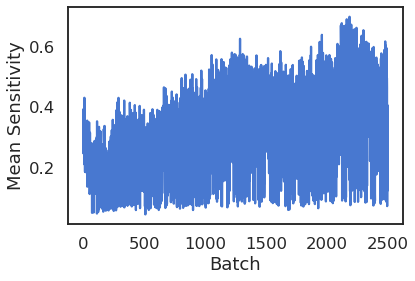

In [163]:
#the info tuple holds: (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, all_means)
batch_mean_sensitivities = info_tuple[6]
batch_max_sensitivities = info_tuple[7]

plt.plot(batch_mean_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Mean Sensitivity")

Text(0, 0.5, 'Max Sensitivity')

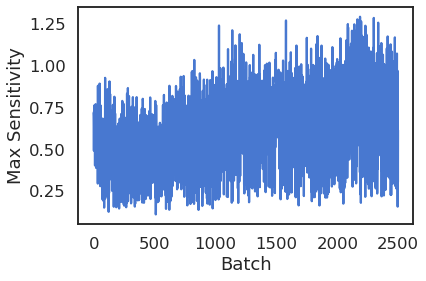

In [164]:
plt.plot(batch_max_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Max Sensitivity")

# IS *DOES* Increase Per Epoch

Text(0, 0.5, 'Max Sensitivity')

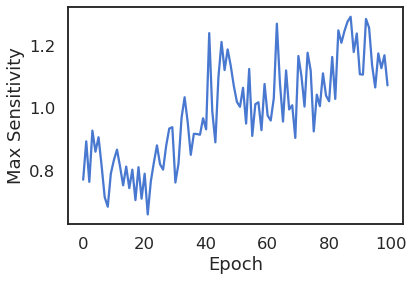

In [166]:
plt.plot(info_tuple[1])
plt.xlabel("Epoch")
plt.ylabel("Max Sensitivity")

# Accuracy Increases as Epsilon Increases

(as expected)

In [165]:
accuracies = []
epsilons = [0.01, 0.1, 1.0, 10.0]

for epsilon in epsilons:
    accuracies.append(np.mean([run_experiment(epsilon)[0] for _ in range(5)]))

Start of epoch 0
Max batch sensitivity for the epoch: 1.2892588376998901
Mean batch sensitivity for the epoch: 0.996284327507019
Max sigma for the epoch: 729.3149334738231
Mean sigma for the epoch: 563.583523176074
Accuracy: 0.47
Start of epoch 1
Max batch sensitivity for the epoch: 1.3398288488388062
Mean batch sensitivity for the epoch: 1.0052150678634644
Max sigma for the epoch: 757.9216517146284
Mean sigma for the epoch: 568.6355128297209
Accuracy: 0.48
Start of epoch 2
Max batch sensitivity for the epoch: 1.403107762336731
Mean batch sensitivity for the epoch: 1.0251167559623717
Max sigma for the epoch: 793.7176107870281
Mean sigma for the epoch: 579.8936077191586
Accuracy: 0.485
Start of epoch 3
Max batch sensitivity for the epoch: 1.3713325262069702
Mean batch sensitivity for the epoch: 1.0547149336338044
Max sigma for the epoch: 775.742822834102
Mean sigma for the epoch: 596.636865432946
Accuracy: 0.475
Start of epoch 4
Max batch sensitivity for the epoch: 1.3510774374008179
Me

Text(0, 0.5, 'Accuracy')

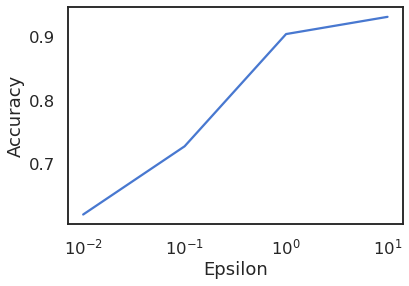

In [170]:
plt.plot(epsilons, accuracies)
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')